# Estimate of Public Jupyter Notebooks on GitHub

This notebook shows the historical count and future estimate of the number of `*.ipynb` files on GitHub. The daily count comes from executing the query [extension:ipynb nbformat_minor](https://github.com/search?utf8=%E2%9C%93&q=extension%3Aipynb+nbformat_minor) once a day, on most days. We re-render the notebook and publish it daily after the update.

## Assumptions

1. That the search query hits and notebooks on GitHub are in 1:1 correspondence.
1. That GitHub is accurately reporting the total number of `*.ipynb` file hits.
1. That the result is **not** inflated due to GitHub forks.
    * Evidence: We do not see the tutorial notebooks from the ipython/ipython GitHub repository duplicated in the search results because of the 2,000+ forks of the ipython/ipython repo.
1. That the result **is** inflated a tiny bit by manually created duplicates of notebooks.
    * Evidence: Some people seem to download their favorite notebooks and then upload them into their own git repositories for safe keeping.

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline

In [3]:
import time
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from __future__ import division

In [4]:
mpl.style.use('ggplot')
figsize = (14,7)

In [5]:
today = time.strftime("%Y-%m-%d")
print('This notebook was last rendered on {}.'.format(today))

This notebook was last rendered on 2017-01-21.


## Raw Hits

First, let's load the historical data into a DataFrame indexed by date.

In [6]:
hits_df = pd.read_csv('ipynb_counts.csv', index_col=0, header=0, parse_dates=True)
hits_df.reset_index(inplace=True)
hits_df.drop_duplicates(subset='date', inplace=True)
hits_df.set_index('date', inplace=True)
hits_df.sort_index(ascending=True, inplace=True)

In [7]:
hits_df.tail(3)

,hits
date,
2017-01-18,691422
2017-01-19,692056
2017-01-21,696018


There might be missing counts for days that we failed to sample. We build up the expected date range and insert NaNs for dates we missed.

In [8]:
til_today = pd.date_range(hits_df.index[0], hits_df.index[-1])

In [9]:
hits_df = hits_df.reindex(til_today)

Now we plot the known notebook counts for each day we've been tracking the query results.

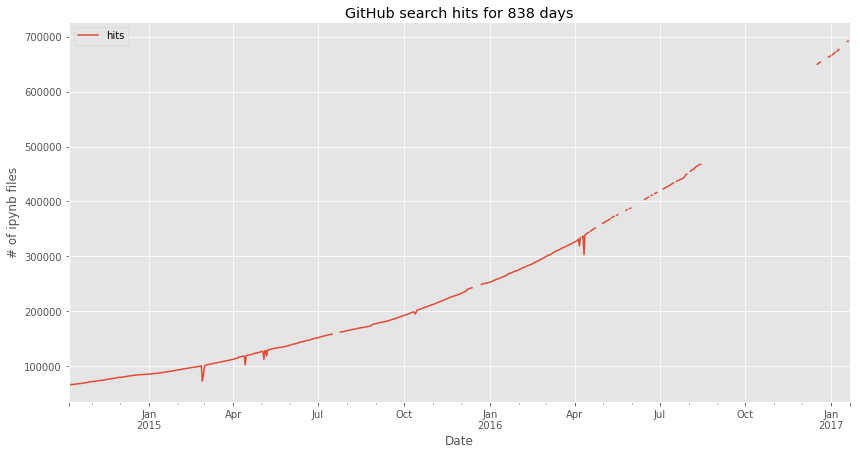

In [10]:
ax = hits_df.plot(title="GitHub search hits for {} days".format(len(hits_df)), figsize=figsize)
ax.set_xlabel('Date')
ax.set_ylabel('# of ipynb files')

## Smoothed Hits

The outliers in the data are from GitHub reporting drastically different counts when we sample. We suspect this happens when they rebuild their search index. We'll filter them out now by removing any daily change greater than 2.5 standard deviations from the mean daily change.

In [11]:
daily_deltas = (hits_df.hits - hits_df.hits.shift()).fillna(0)

In [12]:
outliers = abs(daily_deltas - daily_deltas.mean()) > 2.5*daily_deltas.std()

In [13]:
hits_df.ix[outliers] = np.NaN

Now we'll do simple linear interpolation for any missing values over days that we failed to sample and days that had outlier counts.

In [14]:
hits_df = hits_df.interpolate(method='time')

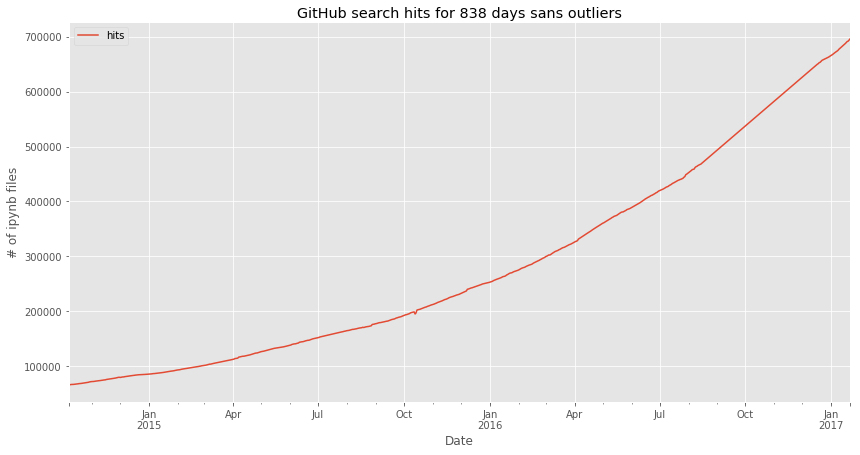

In [15]:
ax = hits_df.plot(title="GitHub search hits for {} days sans outliers".format(len(hits_df)), 
                  figsize=figsize)
ax.set_xlabel('Date')
_ = ax.set_ylabel('# of ipynb files')

The total change in the number of `*.ipynb` hits between the tracking start date and today is:

In [16]:
total_delta_nbs = hits_df.iloc[-1] - hits_df.iloc[0]
total_delta_nbs

hits    630170.0
dtype: float64

## Daily Change

The daily average change is:

In [17]:
avg_delta_nbs = total_delta_nbs / len(hits_df)
avg_delta_nbs

hits    751.99284
dtype: float64

We can look at the daily change over the entire period. We can also plot the rolling 30-day mean of the daily deltas.

In [18]:
daily_deltas = (hits_df.hits - hits_df.hits.shift()).fillna(0)

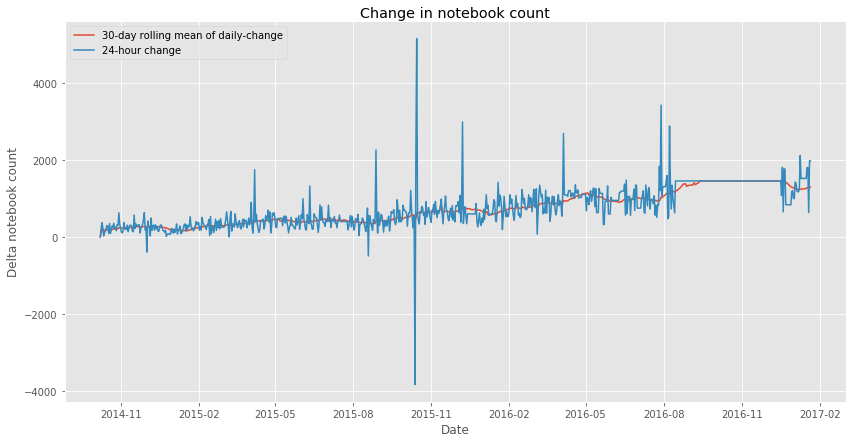

In [19]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(pd.rolling_mean(daily_deltas, window=30, min_periods=0), 
        label='30-day rolling mean of daily-change')
ax.plot(daily_deltas, label='24-hour change')
ax.set_xlabel('Date')
ax.set_ylabel('Delta notebook count')
ax.set_title('Change in notebook count')
_ = ax.legend(loc='upper left')

Let's look at the rolling mean in isolation.

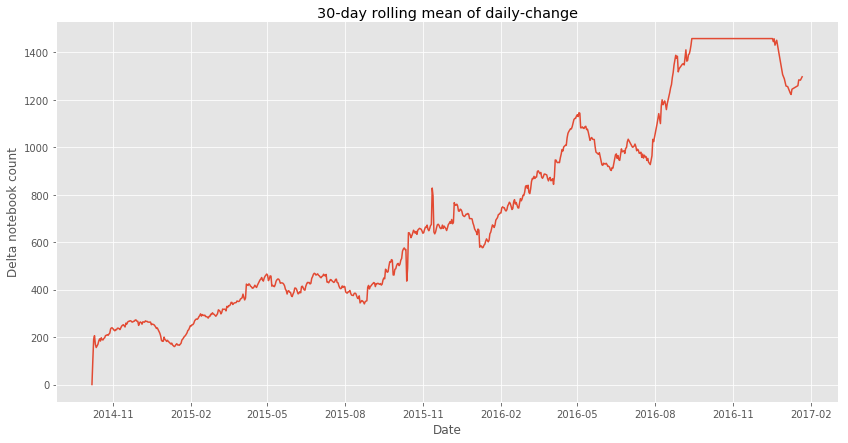

In [20]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(pd.rolling_mean(daily_deltas, window=30, min_periods=0))
ax.set_xlabel('Date')
ax.set_ylabel('Delta notebook count')
_ = ax.set_title('30-day rolling mean of daily-change')

## Count Prediction

We next train an [autoregressive model](http://en.wikipedia.org/wiki/Autoregressive_model) on the time series data. We then use the model to predict the number of notebooks on GitHub a few months out.

In [21]:
def train(df):
    ar_model = sm.tsa.AR(df, freq='D')
    ar_model_res = ar_model.fit(ic='bic')
    return ar_model_res

We look at the model using all data up to and including today's count, plus two historical models.

In [22]:
start_date='2014-10-20'
end_date='2017-06-01'
model_dates = [today, '2016-01-01', '2015-06-01', '2014-11-15']

In [23]:
models = [train(hits_df.loc[:date]) for date in model_dates]

We see that the most recently selected model has more parameters allowed according to the [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) methodology.

In [24]:
pd.DataFrame([m.params for m in models], index=model_dates).T

,2017-01-21,2016-01-01,2015-06-01,2014-11-15
L1.hits,1.112473,1.044508,1.003372,1.001698
L2.hits,-0.280357,-0.343945,NaN,NaN
L3.hits,0.275694,0.302759,NaN,NaN
L4.hits,-0.101691,NaN,NaN,NaN
L5.hits,0.035217,NaN,NaN,NaN
L6.hits,0.082176,NaN,NaN,NaN
L7.hits,0.032992,NaN,NaN,NaN
L8.hits,-0.058435,NaN,NaN,NaN
L9.hits,-0.096869,NaN,NaN,NaN
const,66.648227,54.362348,-22.485983,116.524522


We predict everything from the start date to the end date, using the model values throughout the range of known truth.

In [25]:
predictions = [model.predict(start=start_date, end=end_date, dynamic=True) for model in models]

We put all of the predictions in a DataFrame alongside the ground truth for plotting.

In [26]:
eval_df = pd.DataFrame(predictions, index=model_dates).T

In [27]:
eval_df['truth'] = hits_df.hits

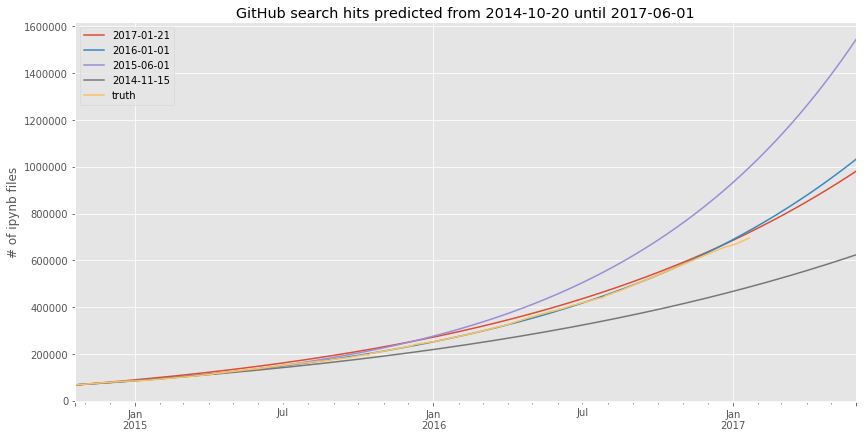

In [28]:
title = 'GitHub search hits predicted from {} until {}'.format(start_date, end_date)
ax = eval_df.plot(title=title, figsize=figsize)
_ = ax.set_ylabel('# of ipynb files')

We plot the residuals for each model to get a sense of how accurate it is as time marches on.

In [29]:
residual_df = -eval_df.subtract(eval_df.truth, axis=0).dropna().drop('truth', axis=1)

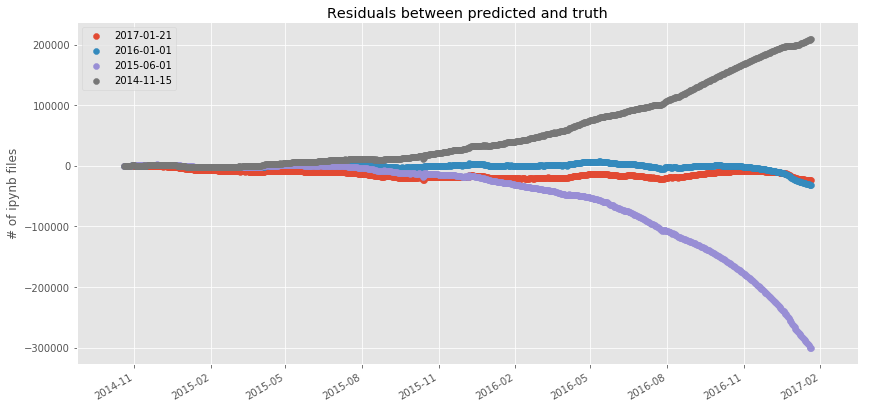

In [30]:
fig, ax = plt.subplots(figsize=figsize)
for i, (name, column) in enumerate(residual_df.iteritems()):
    ax.scatter(residual_df.index, column, c=mpl.rcParams['axes.color_cycle'][i], label=name)
ax.legend(loc='upper left')
ax.set_ylabel('# of ipynb files')
ax.set_title('Residuals between predicted and truth')
fig.autofmt_xdate()